# Сборный проект - 1: исследование рынка компьютерных игр

Перед нами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и мы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Не важно, прогнозируем ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.
В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

* [Загрузка и обзор данных](#1)
* [Предобработка данных](#2)
* [Обзор истории рынка, цикл жизни платформы](#3)
* [Бестселлеры, влияние оценок, жанры](#4)
* [Региональные различия](#5)
* [Проверка гипотез](#6)
* [Общий вывод](#7)

<a id='1'></a>
# Шаг 1.
Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


df = pd.read_csv('https://code.s3.yandex.net/datasets/games.csv')

df.info()

df.head(20)
#df.tail(20)

#Выведем количество пропусков в колонках, где пропуски есть:
for column in df.columns:
    if df[column].isna().sum() != 0:
        print('Количество пропусков в колонке {}: {}'.format(column, df[column].isna().sum()))
    

print('\nКоличество дубликатов в колонке "Name": {}'.format(df.Name.duplicated().sum()))




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
Количество пропусков в колонке Name: 2
Количество пропусков в колонке Year_of_Release: 269
Количество пропусков в колонке Genre: 2
Количество пропусков в колонке Critic_Score: 8578
Количество пропусков в колонке User_Score: 6701
Количество п

Имеем датафрейм из 16715 записей в 11 колонок.
Очень значительная часть оценок и рейтингов пропущена, и заполнить их не представляется возможным.
Пропущено 269 дат в столбце "год релиза" - это менее 2% от общего размера выборки.
Так же 5155 повторов в названиях игр. Это обусловлено тем, что одна и та же игра часто выходила на нескольких разных платформах. При сведении таблиц эту особенность следует учесть.

<a id='2'></a>
# Шаг 2. Подготовьте данные

- Замените названия столбцов (приведите к нижнему регистру);
- Преобразуйте данные в нужные типы. Опишите, в каких столбцах заменили тип данных и почему;
- Обработайте пропуски при необходимости:
- Объясните, почему заполнили пропуски определённым образом или почему не стали это делать;
- Опишите причины, которые могли привести к пропускам;
- Обратите внимание на аббревиатуру 'tbd' в столбцах с рейтингом. Отдельно разберите это значение и опишите, как его обработать;
- Посчитайте суммарные продажи во всех регионах и запишите их в отдельный столбец.


In [2]:
#Приведем название столбцов к нижнему регистру:
df.columns = df.columns.str.lower()

for column in ['genre']:
    df[column] = df[column].str.lower()
    
# Преобразуем год релиза в целое число:
df.year_of_release = df.year_of_release.astype('Int16')
        
df.head()

# Количество оценок со значением tbd (to be determined):
print('Количество оценок со значением tbd (to be determined): {}', 
      df[df['user_score'] == 'tbd']['user_score'].count())

# Заменим tbd на NaN:

df.user_score = df.user_score.replace('tbd', np.NaN)
df.user_score = df.user_score.astype('float32') 


# Заполним пропуски в столбце "год релиза" и выведем результат:
# Составим словарь со значениями года выхода той же игры, но на других платформах. Будем выбирать самый поздний (max) год:
year_of_release_dict = df[df['year_of_release'].notna()].pivot_table(index = 'name', 
                        values = ['year_of_release'], aggfunc = 'max').to_dict()

#Напишем функцию, заменяющую пропуск в дате релиза на значение из словаря, если в словаре имеется запись с нужным ключом:
def fill_year(data):
    if pd.isna(data['year_of_release']) & (data['name'] in year_of_release_dict['year_of_release'].keys()):
        
        return year_of_release_dict['year_of_release'][data['name']]
    return data['year_of_release']

df['year_of_release'] = df.apply(fill_year, axis = 1)

# Проверим результат, сколько пропусков осталось:
print('Осталось пропусков в колонке Year_of_Release: {}'.format(df['year_of_release'].isna().sum()))


Количество оценок со значением tbd (to be determined): {} 2424
Осталось пропусков в колонке Year_of_Release: 146


    1) Приведем к нижнему регистру названия столбцов для удобства обращения к ним.
    2) Преобразуем год релиза в целое число.
    3) Одним из значений в столбце "оценка пользователей" является "tbd", что ни что иное как "to be defined" - слишком мало отзывов пользователей получено, чтобы посчитать метрику. Для нас это равносильно пропуску. Заменим "tbd" на пропуск при помощи метода "replace". Кстати, теперь тип данных "object" не имеет оснований - в колонке содержатся либо пропуски, либо дробные числа. Заменим тип на "float".
    4) Заполним пропуски в "год релиза", если возможно найти год выхода той же игры на другой платформе. Удалось избавиться почти от половины пропусков.

In [3]:

# Выкинем НаНы в годах релиза:

#df['year_of_release'].dropna(inplace = True)


# Создаем колонку с суммарными продажами в мире:
df['global_sales'] = sum(df[column] for column in ['na_sales', 'eu_sales', 'jp_sales', 'other_sales'])

display(df.head())


name platform year_of_release         genre  na_sales  \
0                Wii Sports      Wii            2006        sports     41.36   
1         Super Mario Bros.      NES            1985      platform     29.08   
2            Mario Kart Wii      Wii            2008        racing     15.68   
3         Wii Sports Resort      Wii            2009        sports     15.61   
4  Pokemon Red/Pokemon Blue       GB            1996  role-playing     11.27   

   eu_sales  jp_sales  other_sales  critic_score  user_score rating  \
0     28.96      3.77         8.45          76.0         8.0      E   
1      3.58      6.81         0.77           NaN         NaN    NaN   
2     12.76      3.79         3.29          82.0         8.3      E   
3     10.93      3.28         2.95          80.0         8.0      E   
4      8.89     10.22         1.00           NaN         NaN    NaN   

   global_sales  
0         82.54  
1         40.24  
2         35.52  
3         32.77  
4         31.38

Дополним датафрейм колонкой с глобальными продажами. Проверим, успешно ли прошла операция при помощи вывода таблицы на экран. 

# Шаг 3. Проведите исследовательский анализ данных.

- Посмотрите, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
- Посмотрите, как менялись продажи по платформам. Выберите платформы с наибольшими суммарными продажами и постройте распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?
- Возьмите данные за соответствующий актуальный период. Актуальный период определите самостоятельно в результате исследования предыдущих вопросов. Основной фактор — эти данные помогут построить прогноз на 2017 год.
- Не учитывайте в работе данные за предыдущие годы.
- Какие платформы лидируют по продажам, растут или падают? Выберите несколько потенциально прибыльных платформ.
- Постройте график «ящик с усами» по глобальным продажам игр в разбивке по платформам. Опишите результат.
- Посмотрите, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Постройте диаграмму рассеяния и посчитайте корреляцию между отзывами и продажами. Сформулируйте выводы.
- Соотнесите выводы с продажами игр на других платформах.
- Посмотрите на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?
<a id='3'></a>

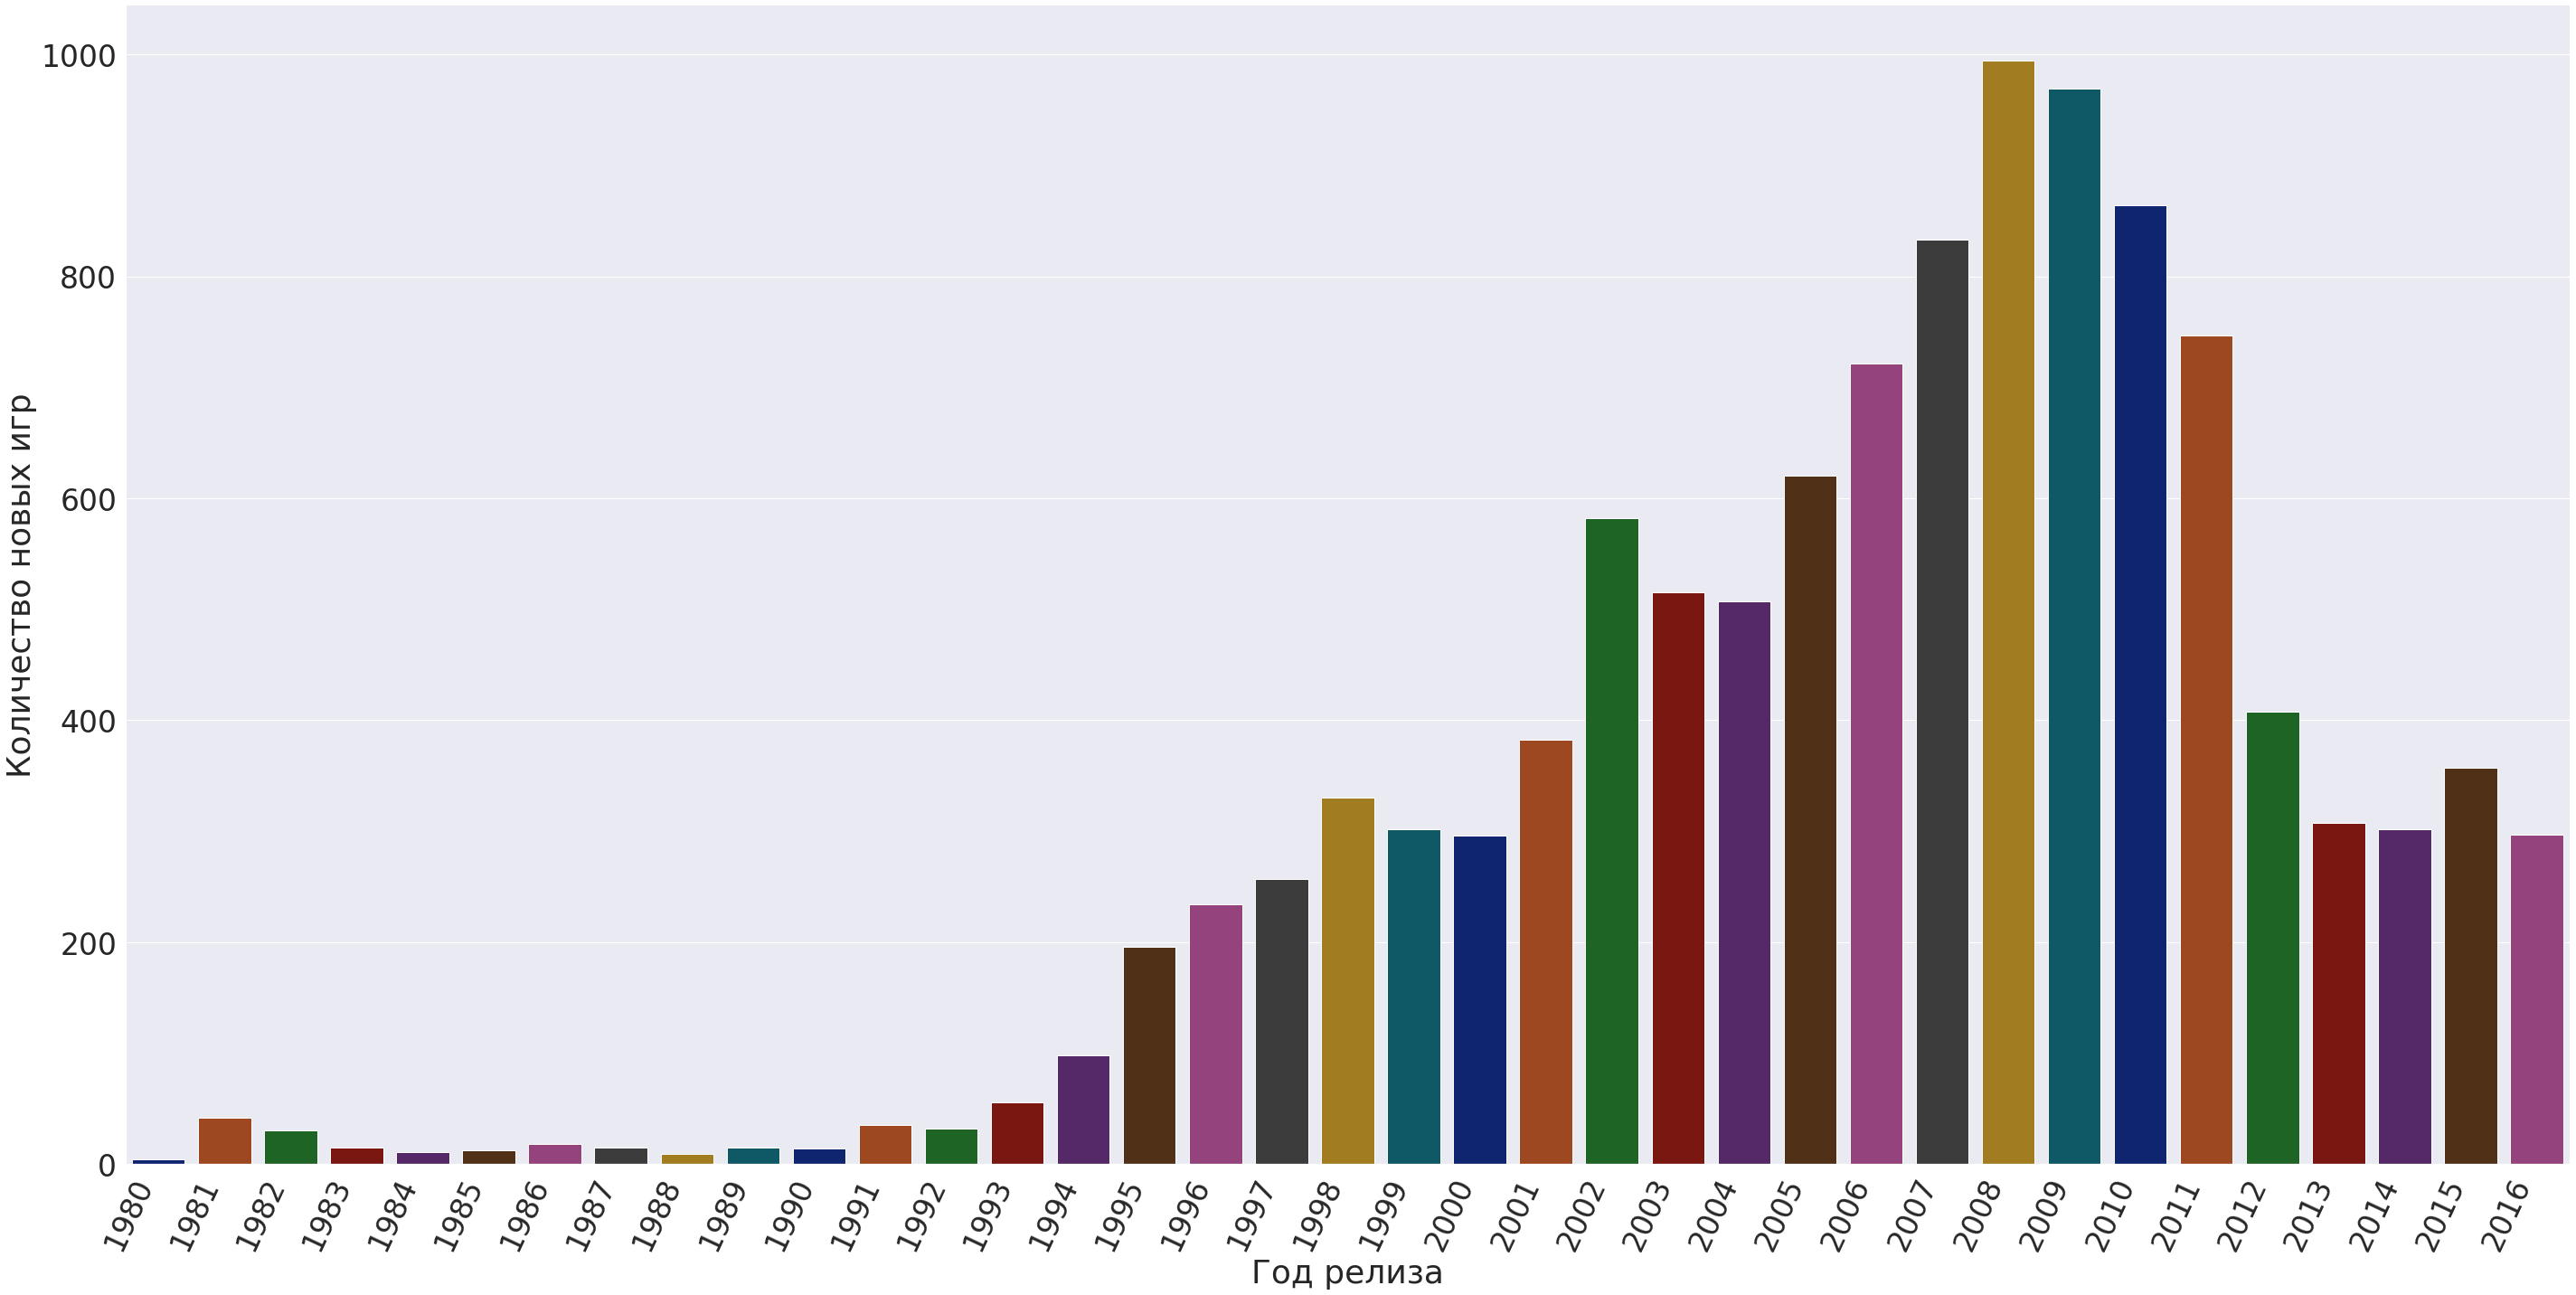

In [4]:



df_games = df.pivot_table(index='name', values = 'year_of_release', aggfunc = 'max').reset_index(level = 'name')


df_games['year_of_release'] = df_games['year_of_release'].astype('Int16')

sns.set(font_scale = 3)
ax = sns.catplot(x = "year_of_release", kind = "count", palette = 'dark', 
            data = df_games, height = 20, aspect = 2).set_xticklabels(rotation = 65, 
            horizontalalignment = 'right').set(xlabel='Год релиза', ylabel='Количество новых игр')



# Отсечём релизы до 1995 года - т.к. это год начала взрывного роста индустрии.
df = df[df['year_of_release'] > 1995 ]


Создадим сводную таблицу по именам, чтобы избежать учёта повторов - нас интересует именно количество новых игр, а не релизов, поскольку порт игры с платформы на платформу, как правило, требует куда меньших усилий, чем разработка игры с нуля, отсюда приравнивать одно к другому для оценки индустрии в целом нельзя.

Из графика следует:

    1) Взрыв активности в игровой индустрии можно отсчитывать с 1995 года - именно тогда наметился устойчивый тренд к взрывному росту игровой индустрии. Этот год, кроме того, знаменит как год, когда начал надуваться знаменитый "пузырь доткомов", лопнувший в начале 2000 года, чтобы уступить место следующему финансовому пузырю, сдувшемуся уже в 2008. В принципе, мы можем проследить все эти тенденции и на графике. Совпадение? Не думаю!
    
    2) После 2008 года наблюдается резкое падение количества выпускаемых игр на рассматриваемых платформах. Это может быть связано как с неизбежной монополизацией на игровом рынке (маленькие компании-разработчики растворились в составе ИТ-гигантов), так и с экспоненциальным ростом рынка мобильных игр на платформах Android и iOS, которые в изучаемой выборке не представлены. 

Platform life cycle
platform                     
2600                        0
3DS                         6
DC                         10
DS                          9
GB                          5
GBA                         7
GC                          6
N64                         8
NG                          0
PC                         20
PCFX                        0
PS                          7
PS2                        11
PS3                        11
PS4                         3
PSP                        11
PSV                         5
SAT                         3
SNES                        3
WS                          2
Wii                        10
WiiU                        4
X360                       11
XB                          8
XOne                        3

Средняя продолжительность жизни платформы: 6.52


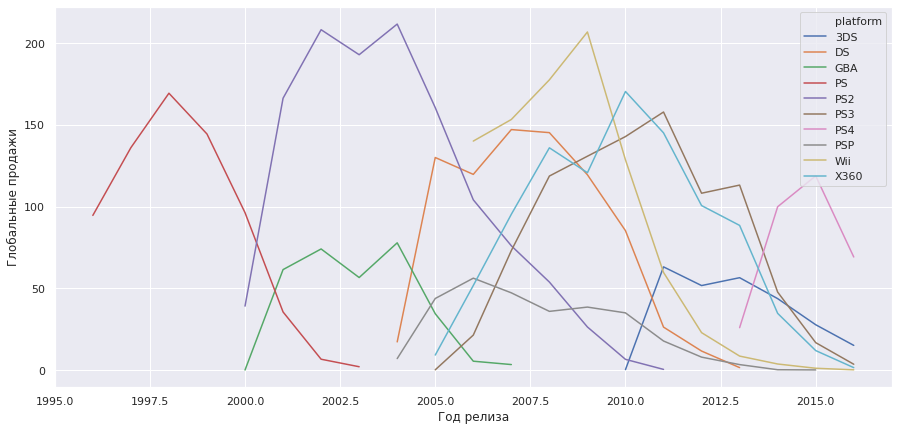

In [5]:

df_platforms = df.pivot_table(index = ['platform', 'year_of_release'], 
                              values = 'global_sales', aggfunc = 'sum').reset_index(level = ['platform', 'year_of_release'])

df_platforms['year_of_release'] = df_platforms['year_of_release'].astype('Int16')

df_top_platforms = df_platforms.groupby('platform')['global_sales'].sum().sort_values(ascending = False).head(10).reset_index(level = ['platform'])['platform']

plt.figure(figsize=(15,7))

sns.set(font_scale = 1)
ax1 = sns.lineplot(x = "year_of_release", y = "global_sales", 
                   hue = "platform",  data=df_platforms[df_platforms['platform'].isin(df_top_platforms)]).set(xlabel='Год релиза', ylabel='Глобальные продажи')

# Посчитаем обычную продолжительность жизни приставки - год первого и год последнего релиза:
platform_lifetime = df.pivot_table(index = 'platform', 
                                   values = ['year_of_release'], aggfunc = 'max') - df.pivot_table(index = 'platform', 
                                                        values = ['year_of_release'], aggfunc = 'min')
platform_lifetime.columns = ["Platform life cycle"]
display(platform_lifetime)

print('Средняя продолжительность жизни платформы: {}'.format(platform_lifetime['Platform life cycle'].mean()))

На графике представлена динамика мировых продаж игр на десяти самых коммерчески успешных платформах.

    1) Ожидаемая продолжительность жизни игровой приставки - около 6 лет. Для сравнения, кот в домашних условиях проживёт 13-15.
    
    2) Пику игровых продаж одной платформы, как правило, соответствует выход более новой платформы-конкурента: потребители игровых продуктов понемногу перебираются на технологически более совершенную приставку, покидая старую. На графике мы видим эту тенденцию в отношении между PS и PS2, PS2 и Xbox 360, PS3 и PS4. Ближе к концу наблюдаемого периода новых "чемпионов продаж" не наметилось - PS4 скорее всего вошла в фазу своего угасания.

platform  global_sales
0       PS3        590.65
1      X360        553.30
2       PS4        314.14
3       3DS        258.53
4       Wii        225.06
5      XOne        159.32
6        DS        124.89
7        PC        124.82
8      WiiU         82.19
9       PSP         64.55
10      PSV         53.81
11      PS2          7.04

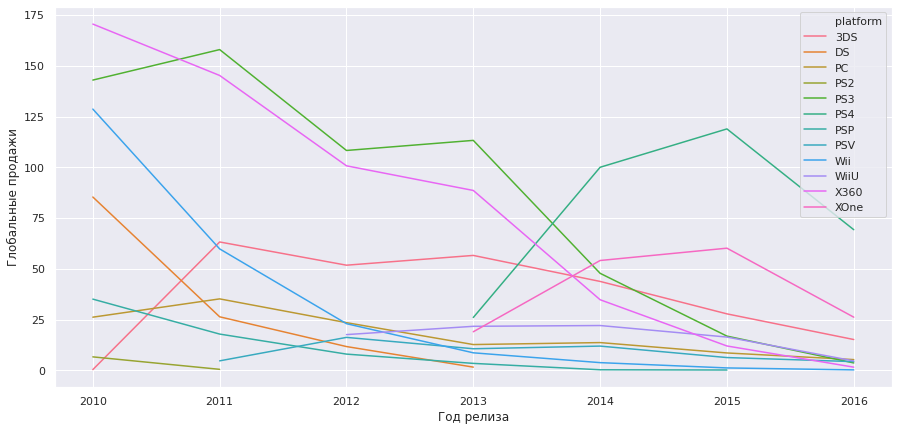

In [6]:

# Исходя из среднего цикла жизни приставки, выделим для рассмотрения последние 6 лет:
df = df.query('year_of_release >= 2010')


df_actual_platforms = df.pivot_table(index = ['platform', 'year_of_release'], 
                              values = 'global_sales', aggfunc = 'sum').reset_index(level = ['platform', 'year_of_release'])

df_actual_platforms['year_of_release'] = df_actual_platforms['year_of_release'].astype('Int16')

df_top_actual_platforms = df.groupby('platform')['global_sales'].sum().sort_values(ascending = False).head(20).reset_index(level = ['platform'])['platform']
display(df.groupby('platform')['global_sales'].sum().sort_values(ascending = False).head(30).reset_index(level = ['platform']))



plt.figure(figsize=(15,7))
sns.set(font_scale = 1)
ax1 = sns.lineplot(x = "year_of_release", y = "global_sales", 
                   hue = "platform",  data=df_actual_platforms[df_actual_platforms['platform'].isin(df_top_actual_platforms)]).set(xlabel='Год релиза', ylabel='Глобальные продажи')


Рассмотрим более детально, исходя из ожидаемого срока жизни платформы, последние 6 лет жизни индустрии для поиска перспективной платформы. Здесь так же не удаётся обнаружить "восходящих" трендов. Все платформы теряют в продажах. Более-менее "на плаву" - PS4 и его конкурент Xbox One.
<a id='4'></a>

Продажи 90% игр на Xbox 360 не превышают 1.74 млн. копий

Продажи 90% игр на PlayStation 3 не превышают 1.4 млн. копий

Xbox 360 top sales:
                   name  global_sales platform
14  Kinect Adventures!         21.82     X360
23  Grand Theft Auto V         16.27     X360 

PlayStation 3 top sales:
                   name  global_sales platform
16  Grand Theft Auto V         21.05      PS3 



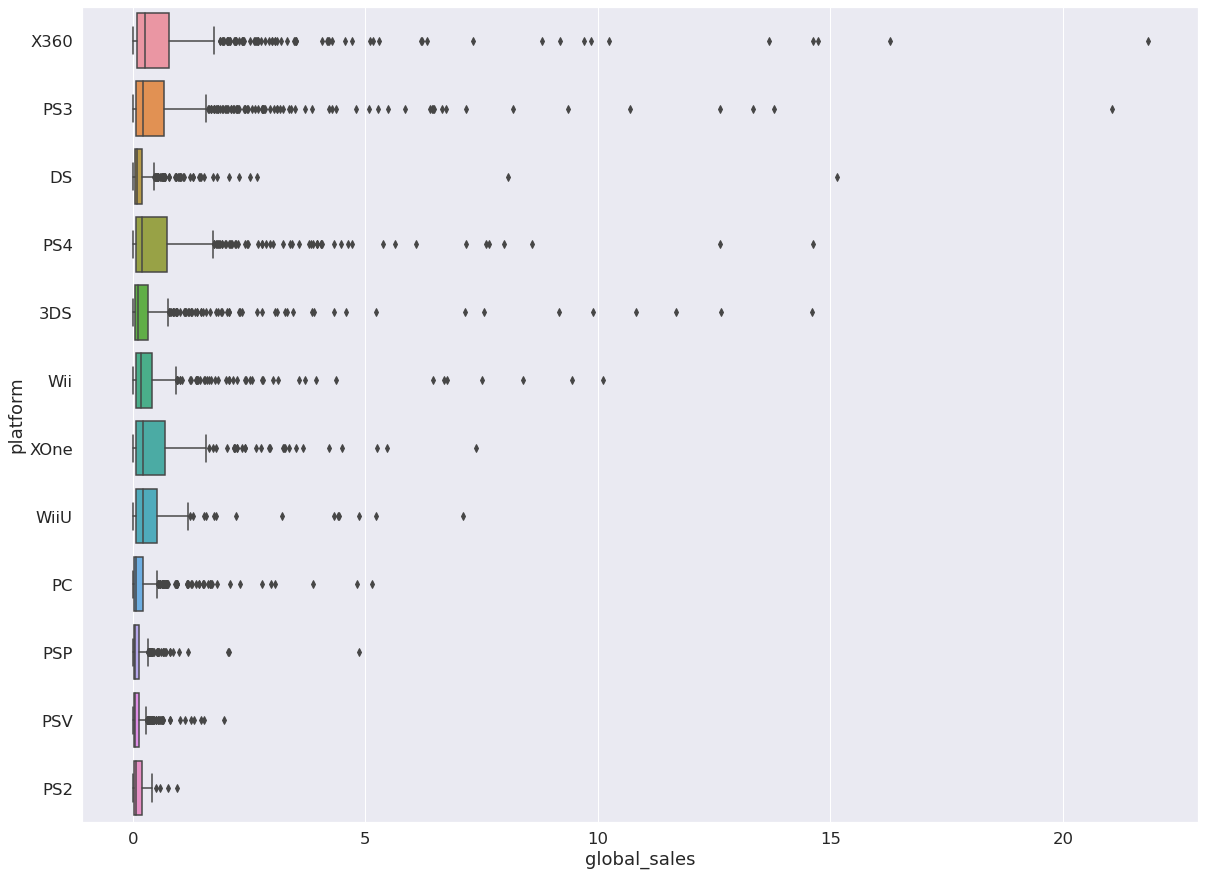

In [7]:

sns.set(font_scale = 1.5)
plt.figure(figsize=(20,15))
ax2 = sns.boxplot(x=df['global_sales'], y = df['platform'])

print('Продажи 90% игр на Xbox 360 не превышают {:.3} млн. копий\n'.format(df.query('platform == "X360"')['global_sales'].quantile(q = 0.90)))
print('Продажи 90% игр на PlayStation 3 не превышают {:.3} млн. копий\n'.format(df.query('platform == "PS3"')['global_sales'].quantile(q = 0.90)))

print('Xbox 360 top sales:\n', df.query('platform == "X360" & global_sales > 15')[['name', 'global_sales', 'platform']], '\n')
print('PlayStation 3 top sales:\n',df.query('platform == "PS3" & global_sales > 15')[['name', 'global_sales', 'platform']], '\n')


"Выбросы" в данном случае - бестселлеры, продажи которых сильно превзошли медианные продажи проектов на платформе. Самые успешные результаты на этом поприще у Xbox 360 - при том что для 90% игр удается продать не более 1.88 миллионов копий, два проекта смогли реализовать 16 и 21 миллион копий соответственно. Это "Grand Theft Auto V" и "Kinect Adventures!". Следом идёт PlayStation 3, реализующая не более 1.42 миллионов копий для 90% релизов - и тут на общем фоне выгодно выделяется "Grand Theft Auto V", которая была куплена 21.05 миллиона раз. Не потрачено!

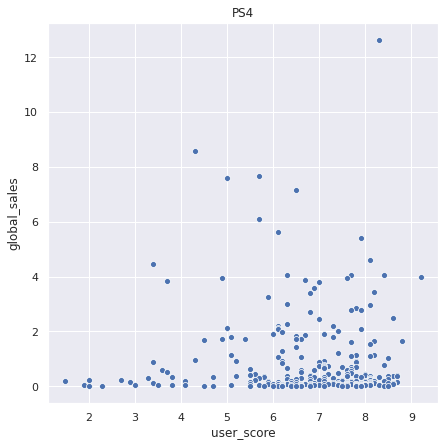

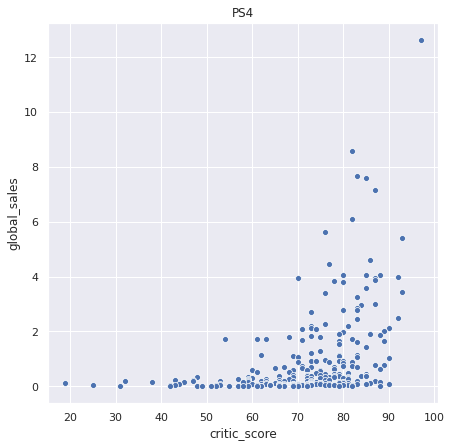

In [8]:
sns.set(font_scale = 1)

for score in ['user_score', 'critic_score']:
    plt.figure(figsize=(7,7))
    ax3 = sns.scatterplot(x = score, y =  'global_sales', data = df.query('platform == "PS4"')).set_title('PS4')
    plt.show()

In [9]:
for param in ['user_score', 'critic_score']:
        
    print('Коэффициент корреляции между параметрами global_sales и {}: {}'.format(param, df['global_sales'].corr(df[param])))
    
#print(df.query('critic_score > 95 & global_sales > 10'))



Коэффициент корреляции между параметрами global_sales и user_score: 0.05442395801979598
Коэффициент корреляции между параметрами global_sales и critic_score: 0.31627751428006395


Оценки пользователей никак не влияют на продажи игрового продукта - большая часть покупок происходит сразу после релиза, когда ничего, кроме рекламы и отзывов "независимых" игровых журналистов, ещё не доступно. Грамотная рекламная кампания - основа коммерческого успеха.
Коэффициенты корреляции отражают те же самые закономерности, что выявлены нами на диаграмме рассеяния.

<AxesSubplot:xlabel='genre', ylabel='platform'>

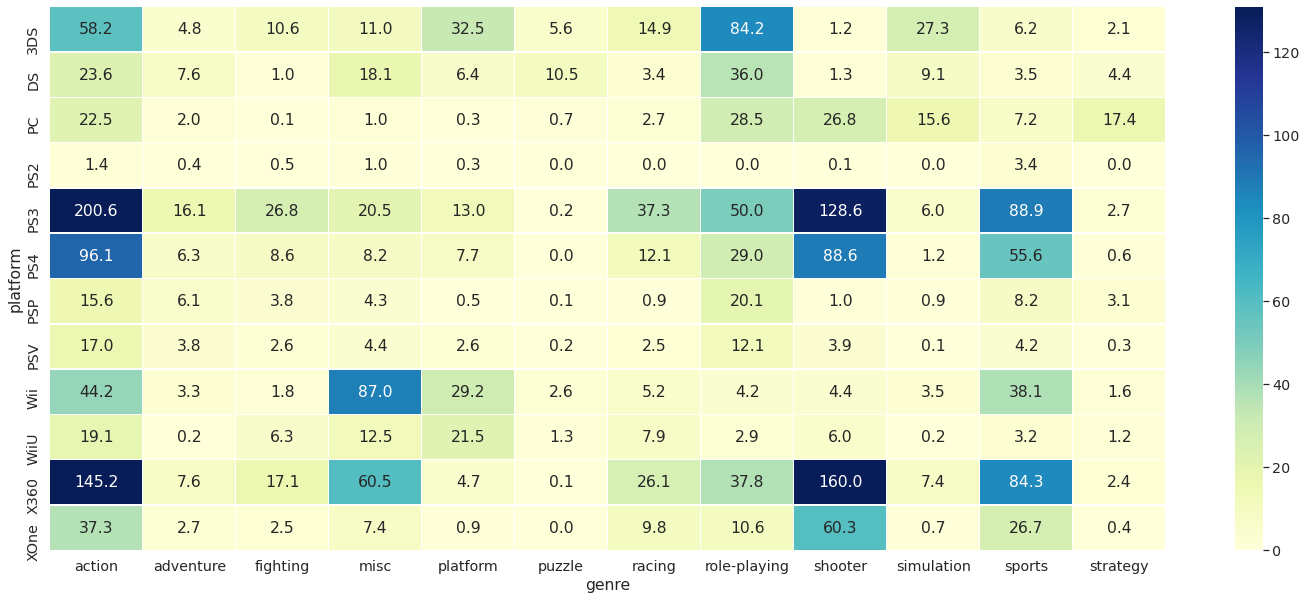

In [10]:
plt.figure(figsize=(25,10))
sns.set(font_scale = 1.3)
#df.pivot_table(index='platform', columns='genre', values='global_sales', 
#                        aggfunc=sum).fillna(0).applymap(float)
sns.heatmap(df.pivot_table(index='platform', columns='genre', values='global_sales', 
                        aggfunc=sum).fillna(0).applymap(float), annot=True, fmt=".1f", linewidths=.5, cmap="YlGnBu", robust = True)

К самым популярным жанрам относятся "Action", "Shooter" и "Sports". У некоторых платформ есть свои "нишевые" жанры, которые особенно хорошо продаются именно на этой платформе. Таковы, "Strategy" на PC и "Puzzle" на Nintendo DS и 3DS. 


<a id='5'></a>
# Шаг 4. Составьте портрет пользователя каждого региона

- Определите для пользователя каждого региона (NA, EU, JP):
- Самые популярные платформы (топ-5). Опишите различия в долях продаж.
- Самые популярные жанры (топ-5). Поясните разницу.
- Влияет ли рейтинг ESRB на продажи в отдельном регионе?

In [11]:
import plotly.graph_objects as go
# Рассмотрим глобальный рынок в целом:

colors = ['mediumturquoise', 'lightgreen', 'gold', 'darkorange']
fig = go.Figure(data=[go.Pie(labels=['в Северной Америке','в Европе','в Японии','в прочих регионах'],
                             values=[df['na_sales'].sum(), df['eu_sales'].sum(), df['jp_sales'].sum(), df['other_sales'].sum()])])
fig.update_traces(hoverinfo='label+percent', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))
fig.update_layout(
    title_text="Распределение глобальных продаж по регионам с 2010 года по 2016 (млн. проданных копий): ",
    )
fig.show()

Прежде чем изучать каждый регион в отдельности, посмотрим, что представляет собой глобальный рынок как целое. 
77% проданных за последние 6 лет копий игр были реализованы в США и Европе. Япония и "прочие страны" поровну делят между собой оставшиеся 23% рынка.  

'Топ 5 платформ по продажам в Северной Америке:'

platform  na_sales
0     X360    335.93
1      PS3    230.47
2      Wii    122.68
3      PS4    108.74
4     XOne     93.12

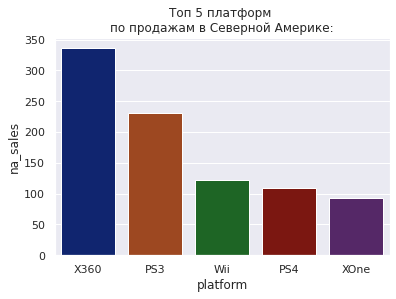

'Топ 5 жанров по продажам в Северной Америке:'

genre  na_sales
0        action    294.26
1       shooter    238.50
2        sports    157.49
3          misc    124.39
4  role-playing    112.05

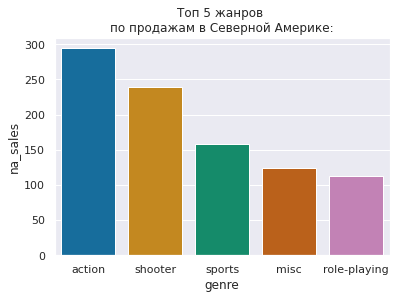

'Топ 5 платформ по продажам в Европе:'

platform  eu_sales
0      PS3    214.74
1     X360    164.29
2      PS4    141.09
3       PC     70.50
4      Wii     66.35

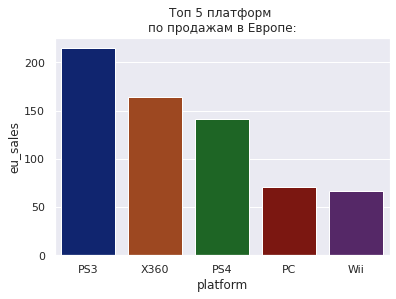

'Топ 5 жанров по продажам в Европе:'

genre  eu_sales
0        action    236.70
1       shooter    172.57
2        sports    117.09
3  role-playing     75.48
4          misc     66.55

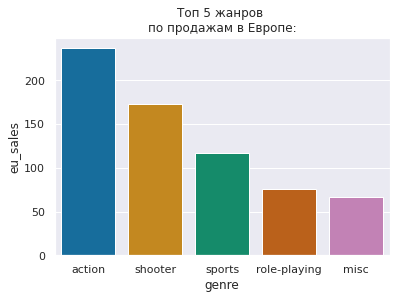

'Топ 5 платформ по продажам в Японии:'

platform  jp_sales
0      3DS    100.64
1      PS3     59.36
2      PSP     42.44
3       DS     27.90
4      PSV     21.84

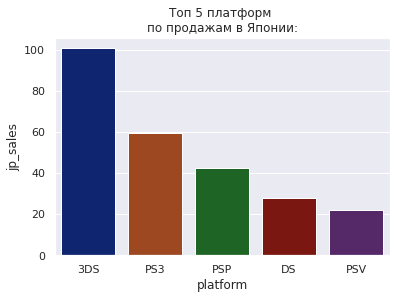

'Топ 5 жанров по продажам в Японии:'

genre  jp_sales
0  role-playing    103.59
1        action     72.21
2          misc     24.54
3      platform     15.81
4     adventure     15.67

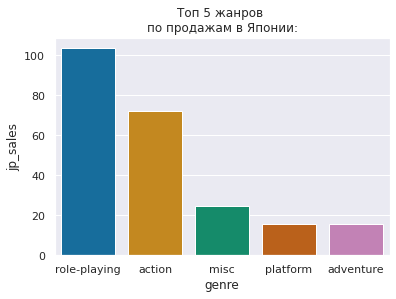

'Топ 5 платформ по продажам в прочих регионах:'

platform  other_sales
0      PS3        86.08
1      PS4        48.35
2     X360        47.61
3      Wii        18.28
4       PC        14.45

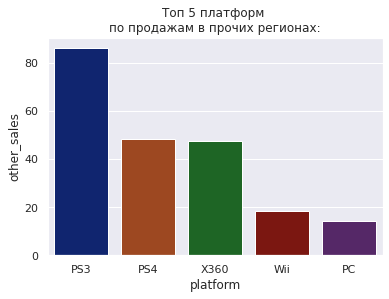

'Топ 5 жанров по продажам в прочих регионах:'

genre  other_sales
0        action        77.51
1       shooter        57.10
2        sports        39.34
3  role-playing        24.21
4          misc        20.52

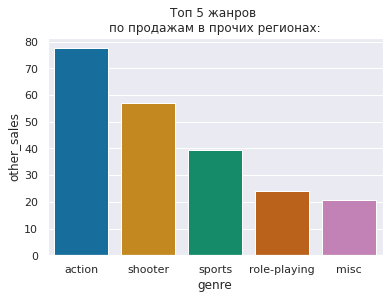

In [12]:
region_dict = {'na_sales': 'в Северной Америке', 'eu_sales': 'в Европе', 'jp_sales' : 'в Японии', 'other_sales': 'в прочих регионах'}
sns.set(font_scale = 1)

for region in ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']:
    top5_platforms = df.pivot_table(index = 'platform', 
                   values = region, aggfunc = 'sum').nlargest(5, region).reset_index(level = 'platform')
    display('Топ 5 платформ по продажам {}:'.format(region_dict[region]), top5_platforms)
    sns.barplot(x=top5_platforms['platform'], y=top5_platforms[region], palette = 'dark').set_title('Топ 5 платформ \nпо продажам {}:'.format(region_dict[region]))
    plt.show()
    
    top5_genres = df.pivot_table(index = 'genre',
                                values = region, aggfunc = 'sum').nlargest(5, region).reset_index(level = 'genre')
    display('Топ 5 жанров по продажам {}:'.format(region_dict[region]), top5_genres)
    sns.barplot(x=top5_genres['genre'], y=top5_genres[region], palette = 'colorblind').set_title('Топ 5 жанров \nпо продажам {}:'.format(region_dict[region]))
    plt.show()
 


    Для Североамериканского региона характерны следующие особенности:
        - Лидирующие позиции на игровом рынке прочно занимает американская корпорация Microsoft со своими Xbox 360 и Xbox One. За ней следует японская Sony с PlayStation 3 и PlayStation 4. 
        
    Для Европейского региона:
        - В отличие от Северной Америки, на европейском рынке ярко выражено лидерство японской Sony. Так же в пятерку лидеров вошел классический ПК - и поработать можно, и поиграть. Практичность! 

    Для регионов:
        - В глаза бросается более ярко выраженное превосходство старых платформ над более новыми - Xbox 360 над Xbox One и PS3 над PS4. Это объясняется тем, что к "прочим регионам" в основном относят наиболее бедные страны, где пользователи стараются выжать максимум из однажды купленного оборудования.
        
    Для Японии: 
        - Ни одна из компаний-производителей платформ в топ-5 не является иностранной. Nintendo и Sony надежно закрепились на родном острове.
        - Жанровые предпочтения японцев так же весьма специфичны - в отличие от остального мира, здесь предпочитают ролевые игры. Почти 50% всех продаж в топ-5 жанрах приходятся на РПГ.
        
        
К ведущим жанрам во всем мире, кроме Японии, относятся экшены, шутеры, спортивные симуляторы и РПГ.

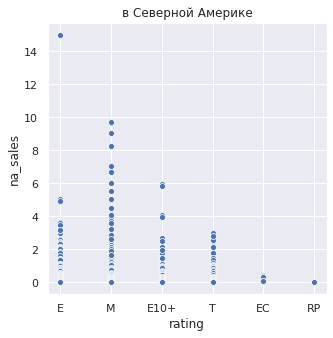

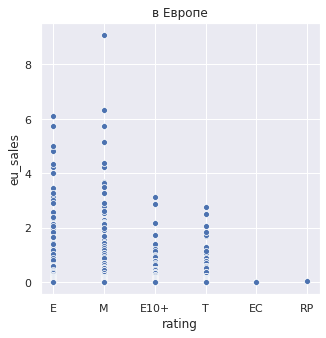

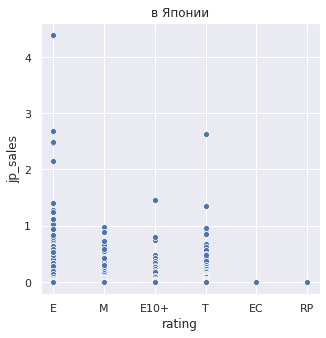

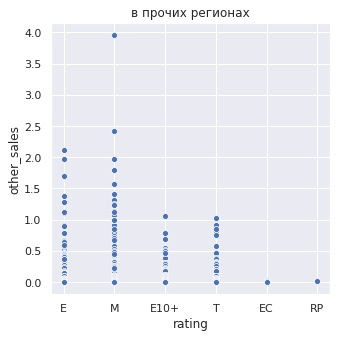

In [13]:

for region in ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']:
    plt.figure(figsize=(5,5))
    ax3 = sns.scatterplot(x =  'rating', y = region, data = df).set_title(region_dict[region])
    plt.show()  
    



В мире наибольшим спросом пользуются продукты категорий "без возрастных ограничений" и "для взрослых". Игры "для тинейджеров" и "для детей старше 10 лет" - нишевый продукт, который пользуется меньшей популярностью.

На общем фоне выделяется Япония - здесь продукты категории 17+ продаются меньше, чем "без ограничений" и "для тинейджеров". Это связано с наиболее популярными жанрами - доминирующие на рынке этой страны РПГ реже получают рейтинг "Mature", чем экшены и шутеры.



<a id='6'></a>
# Шаг 5. Проверка гипотез


- Средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- Средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.
- Задайте самостоятельно пороговое значение alpha.

    Поясните:
    
- Как вы сформулировали нулевую и альтернативную гипотезы;
- Какой критерий применили для проверки гипотез и почему.

Проверим, распределены ли оценки пользователей Xbox One нормально:
p = 1.15351e-05
Нулевая гипотеза отвергнута (гипотеза о нормальном распределении отвергнута)


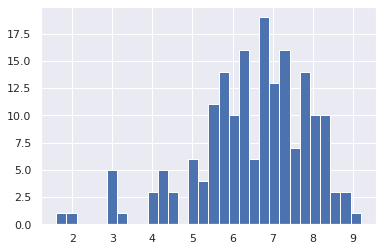


Проверим, распределены ли оценки пользователей ПК нормально:
p = 5.94334e-08
Нулевая гипотеза отвергнута (гипотеза о нормальном распределении отвергнута)


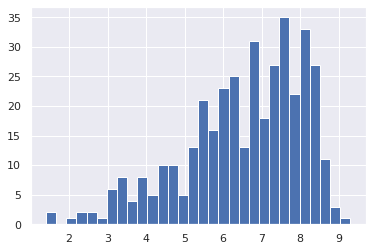


Проверим, распределены ли пользовательские рейтинги жанра Action нормально:
p = 9.07687e-24
Нулевая гипотеза отвергнута (гипотеза о нормальном распределении отвергнута)


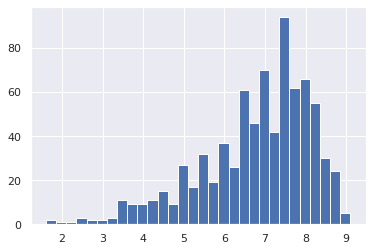


Проверим, распределены ли пользовательские рейтинги жанра Sports нормально:
p = 4.79133e-06
Нулевая гипотеза отвергнута (гипотеза о нормальном распределении отвергнута)


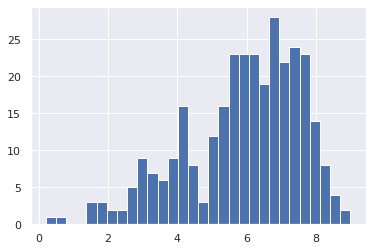

In [14]:
# Сначала определим тип распределения данных:
from scipy import stats as st
# Функция, проверяющая тип распределения:
def normaltest(data, alpha):
    
    k2, p = st.normaltest(data)
    alpha = .05
    print("p = {:g}".format(p))
    
    if p < alpha: # Нулевая гипотеза - выборка принадлежит к нормально распределенной ген. совокупности:
    
        print("Нулевая гипотеза отвергнута (гипотеза о нормальном распределении отвергнута)")
    else:
        print("Нулевая гипотеза не может быть отвергнута (гипотеза о нормальном распределении не может быть отвергнута)")

print('Проверим, распределены ли оценки пользователей Xbox One нормально:')     
normaltest(df.query('platform == "XOne"')['user_score'].dropna(), .05)
df.query('platform == "XOne"')['user_score'].dropna().hist(bins = 30)
plt.show()

print('\nПроверим, распределены ли оценки пользователей ПК нормально:')     
normaltest(df.query('platform == "PC"')['user_score'].dropna(), .05)
df.query('platform == "PC"')['user_score'].dropna().hist(bins = 30)
plt.show()

print('\nПроверим, распределены ли пользовательские рейтинги жанра Action нормально:')     
normaltest(df.query('genre == "action"')['user_score'].dropna(), .05)
df.query('genre == "action"')['user_score'].dropna().hist(bins = 30)
plt.show()

print('\nПроверим, распределены ли пользовательские рейтинги жанра Sports нормально:')     
normaltest(df.query('genre == "sports"')['user_score'].dropna(), .05)
df.query('genre == "sports"')['user_score'].dropna().hist(bins = 30)
plt.show()



Прежде чем выбрать критерий проверки рассматриваемых гипотез, нужно понять, к какому типу распределений относится изучаемая совокупность.
Напишем функцию, с использованием методов библиотеки SciPy проверяющую, является ли распределение нормальным, а так же выведем наглядную гистограмму распределения вероятностей. Применим этот метод на четырех изучаемых наборах данных - оценках пользователей на Xbox One и ПК, а так же пользовательских рейтингах в жанрах Action и Sports.

Ни один из наборов данных не имеет нормального распределения. Все распределения смещены вправо, в сторону более высокой оценки.

In [15]:
from scipy import stats as st

# Нулевой гипотезой будет выступать то что средние рейтинги от пользователей Xbox One и PC одинаковые:

result = st.mannwhitneyu(df.query('platform == "XOne"')['user_score'].dropna(), 
                         df.query('platform == "PC"')['user_score'].dropna()
                        )
alpha = .05
print('p-value: {}'.format(result.pvalue))

if result.pvalue < alpha:        
    print('Отвергаем гипотезу H0 о том, что средние рейтинги от пользователей Xbox One и ПК одинаковы')
    
else:
    print('Не удалось отвергнуть гипотезу Н0 о том, что средние рейтинги от пользователей Xbox One и ПК одинаковы')
    
# Нулевой гипотезой будет выступать то что средние пользовательские рейтинги жанров Action и Sports одинаковы: 

result = st.mannwhitneyu(df.query('genre == "action"')['user_score'].dropna(), 
                         df.query('genre == "sports"')['user_score'].dropna()
                        )
alpha = .05
print('p-value: {}'.format(result.pvalue))

if result.pvalue < alpha:        
    print('Отвергаем гипотезу H0 о том, что средние пользовательские рейтинги жанров Action и Sports одинаковы')
    
else:
    print('Не удалось отвергнуть гипотезу Н0 о том, что средние пользовательские рейтинги жанров Action и Sports одинаковы')


p-value: 0.25780059342892386
Не удалось отвергнуть гипотезу Н0 о том, что средние рейтинги от пользователей Xbox One и ПК одинаковы
p-value: 1.0963391202535111e-17
Отвергаем гипотезу H0 о том, что средние пользовательские рейтинги жанров Action и Sports одинаковы


Тип исследуемых данных относится к количественным. Они не подчиняются закону нормального распределения и являются независимыми. Исходя из этого, целесообразно применить критерий Манна-Уитни. 

    1) В качестве первой нулевой гипотезы Н0 примем то что средние рейтинги от пользователей Xbox One и PC одинаковы. Альтернативной гипотезой Н1, в данном случае, будет выступать различие в средних рейтингах пользователей этих двух платформ. Попадание p-value в интервал альфа скажет о том что гипотезу Н0 с высокой надежностью можно отвергнуть.
    
    Не удалось отвергнуть гипотезу Н0.

    2) Во втором случае назначим нулевой гипотезой Н0 то что одинаковы средние пользовательские рейтинги жанров "Action" и "Sports". В качестве H1 выступит гипотеза о различии пользовательских оценок рассматриваемых жанров. Попадание p-value в интервал альфа скажет о том что гипотезу Н0 с высокой надежностью можно отвергнуть.

    
    Отвергаем гипотезу Н0.

<a id='7'></a>
# Шаг 6. Общий вывод

В ходе выполнения проекта были проанализированы исторические данные о продажах игр и их рейтингах с целью выбора наиболее перспективного продукта и планирования рекламной кампании на 2017 год.

1) Была проведена предварительная подготовка предоставленных данных - проверка на пропуски, изменение типа данных и регистра названий столбцов.


2) Был произведен анализ полученных данных, построен ряд графиков, выявлены ключевые особенности и закономерности - как для рынка в исторической перспективе, так и в краткосрочной, как для глобального рынка, так и для региональных. 

3) Осуществлена проверка гипотез о равенстве средних оценок пользователей на платформах Xbox One и PC, а так же о неравенстве этих оценок для жанров "Action" и "Sports".


К основным выводам следует отнести:

    - Рекламные кампании стоит диверсифицировать в зависимости от региона - например, для США сделать ставку на популярные там PlayStation и Xbox в жанрах "Action" и "Shooter", для Японии - на DS Nintendo и PlayStation и жанре РПГ. Если такой возможности нет - наиболее удачной комбинацией будет сосредоточение на платформах PlayStation и Xbox в жанрах "Action", "Shooter" и "Sports" и распределением рекламного бюджета Японии между остальными регионами. Японский рынок составляет менее 12% мирового, разумнее сосредоточиться на оставшихся 88%, где предпочтения потребителей более-менее однородны. 
    
    - Популярность игры на прилавках полностью зависит от рекламных бюджетов проекта: мониторинг ведущих интернет-изданий и игровых выставок заблаговременно позволит распознать, в создание какой потребности инвестированы средства гигантов развлекательной индустрии. Не стоит плевать против ветра: подготовимся к удовлетворению этого спроса.
    
    
    
   